<a href="https://colab.research.google.com/github/natthaphon-wr/cpe393-codingAI/blob/main/Lab6_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab6 - Training Deep Convolutional Neural Network
- Natthaphon Rotechanathamcharoen, 62070501019

Name your file to 62_1019.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method 
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

### Import Class and Function

In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
#from keras import optimizers
from tensorflow.keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd 
import random
import shutil
from keras.models import Model


%matplotlib inline

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

### Create Custom Function

In [ ]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training accuracy')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation accuracy')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

###Define Constant

In [ ]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32

###Import and Explore Data

In [ ]:
# Download Data
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2022-10-10 08:40:40--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.234.160
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.234.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  84.8MB/s    in 6.5s    

2022-10-10 08:40:47 (84.9 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
def prepare_data(filenames, type):
  category = [type] * len(filenames)
  df = pd.DataFrame({
      'Filename': filenames,
      'Category': category
  })

  return df

In [ ]:
# Get filename and category to Dataframe
train_dog = prepare_data(os.listdir("/content/Cat_Dog_data/train/dog"), 1)
train_cat = prepare_data(os.listdir("/content/Cat_Dog_data/train/cat"), 0)
test_dog = prepare_data(os.listdir("/content/Cat_Dog_data/test/dog"), 1)
test_cat = prepare_data(os.listdir("/content/Cat_Dog_data/test/cat"), 0)

# Merge to train set and test set
train_set = train_dog.append(train_cat)
test_set = test_dog.append(test_cat)

print("Shape of Training Set: ", train_set.shape)
print("Shape of Test Set: ", test_set.shape)

Shape of Training Set:  (22500, 2)
Shape of Test Set:  (2500, 2)


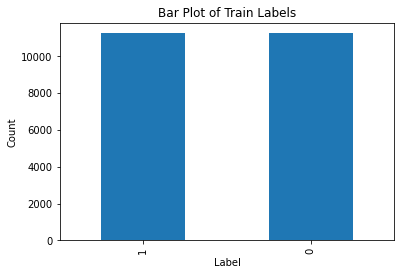

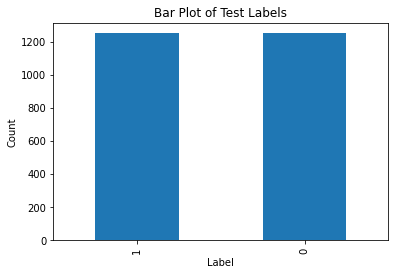

In [ ]:
# View Distribution of Train and Test Data
plt.figure()
plt.title("Bar Plot of Train Labels")
plt.xlabel("Label")
plt.ylabel("Count")
train_set['Category'].value_counts().plot.bar()

plt.figure()
plt.title("Bar Plot of Test Labels")
plt.xlabel("Label")
plt.ylabel("Count")
test_set['Category'].value_counts().plot.bar()

Note: Category 1 means dog, Category 0 means cat. Number of training data is 22500, so my assumption is that data have already been some preprocessing.

###See Sample Images

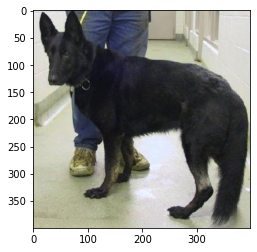

In [ ]:
# See Sample Training Dog Data
sampleIm = random.choice(os.listdir("/content/Cat_Dog_data/train/dog"))
image = load_img("/content/Cat_Dog_data/train/dog/" + sampleIm)
plt.imshow(image)

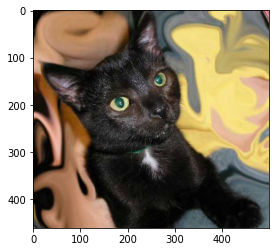

In [ ]:
# See Sample Training Cat Data
sampleIm = random.choice(os.listdir("/content/Cat_Dog_data/train/cat"))
image = load_img("/content/Cat_Dog_data/train/cat/" + sampleIm)
plt.imshow(image)

###Split Train and Validate Data

In [ ]:
train_set["Category"] = train_set["Category"].replace({0: 'cat', 1: 'dog'}) 
test_set["Category"] = test_set["Category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
train_df, validate_df = train_test_split(train_set, test_size=0.2)

In [ ]:
print("Shape of Training: ", train_df.shape)
print("Shape of Validate: ", validate_df.shape)

Shape of Training:  (18000, 2)
Shape of Validate:  (4500, 2)


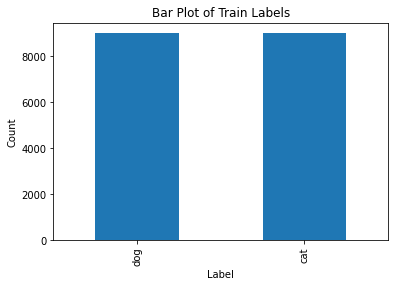

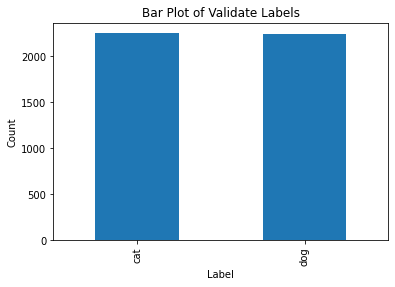

In [ ]:
# View Distribution of Train and Validate Data
plt.figure()
plt.title("Bar Plot of Train Labels")
plt.xlabel("Label")
plt.ylabel("Count")
train_df['Category'].value_counts().plot.bar()

plt.figure()
plt.title("Bar Plot of Validate Labels")
plt.xlabel("Label")
plt.ylabel("Count")
validate_df['Category'].value_counts().plot.bar()

In [ ]:
# Number of Training and Validation Data
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('Number of Training Data: ', total_train)
print('Number of Validation Data: ', total_validate)

Number of Training Data:  18000
Number of Validation Data:  4500


###Data Generator

In [ ]:
# Move File from subfolder to folder (easy for data generation to call directory)
def fetch_files(source_folder, destination_folder):
  for file_name in os.listdir(source_folder):
      source = os.path.join(source_folder, file_name)
      destination = os.path.join(destination_folder, file_name)
      shutil.move(source, destination)


In [ ]:
fetch_files('/content/Cat_Dog_data/train/dog', '/content/Cat_Dog_data/train')
fetch_files('/content/Cat_Dog_data/train/cat', '/content/Cat_Dog_data/train')
fetch_files('/content/Cat_Dog_data/test/dog', '/content/Cat_Dog_data/test')
fetch_files('/content/Cat_Dog_data/test/cat', '/content/Cat_Dog_data/test')

In [ ]:
# Trainging Data Generator and Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory = '/content/Cat_Dog_data/train', 
    x_col  = 'Filename',
    y_col = 'Category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 18000 validated image filenames belonging to 2 classes.


In [ ]:
# Validation Data Generation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    directory = '/content/Cat_Dog_data/train', 
    x_col = 'Filename',
    y_col = 'Category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 4500 validated image filenames belonging to 2 classes.


Note: Found all images (train and validate)

###Use Build-in Pre-Trained Network, Download vgg16

Use vg16 with imagenet

In [ ]:
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

vgg.save('og_vgg16.h5')
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

###Model 1

####Build Model

In [ ]:
# Freeze All Layer
vgg.trainable = False

In [ ]:
# Modified Network to Add Fully Connected Layer and Output Layer
vgg_out = vgg.output
vgg_out = layers.Dropout(0.3, name = 'Dropout1') (vgg_out)
vgg_out = layers.Flatten(name = 'Flatten1') (vgg_out)
vgg_out = layers.Dense(512, activation = 'relu', name = 'Dense1') (vgg_out)
vgg_out = layers.Dropout(0.3, name = 'Dropout2') (vgg_out)

# Noted that 2-classes softmax = sigmoid
out_layer = layers.Dense(2, activation = 'softmax', name = 'output')(vgg_out)

vgg_mod = models.Model(vgg.input, out_layer)
vgg_mod.summary()

In [ ]:
# Compile Model
vgg_mod.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

####Fit Model

In [ ]:
# Callback Function for Early Stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience = 3)

In [ ]:
epochs = 20

history = vgg_mod.fit( 
    train_generator, 
    validation_data = validation_generator,
    epochs = epochs,
    callbacks = [early_stop]
)

vgg_mod.save('vgg_earlyStopping.h5')

Last train accuracy: 0.8255555629730225
Last validation accuracy: 0.8811110854148865


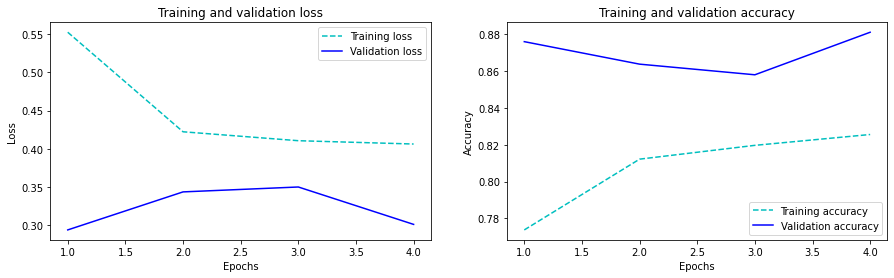

In [ ]:
show_result(history) 

Model isn't good enough. Accuracy of training and validation set are below 90%. I think this model is stopping too early, so the next model will have not early stopping.

###Model 2 Remove Early Stopping

####Build Model

In [ ]:
vgg = models.load_model('og_vgg16.h5')

In [ ]:
# Freeze All Layer
vgg.trainable = False

In [ ]:
# Modified Network to Add Fully Connected Layer and Output Layer
vgg_out = vgg.output
vgg_out = layers.Dropout(0.3, name = 'Dropout1') (vgg_out)
vgg_out = layers.Flatten(name = 'Flatten1') (vgg_out)
vgg_out = layers.Dense(512, activation = 'relu', name = 'Dense1') (vgg_out)
vgg_out = layers.Dropout(0.3, name = 'Dropout2') (vgg_out)

# Noted that 2-classes softmax = sigmoid
out_layer = layers.Dense(2, activation = 'softmax', name = 'output')(vgg_out)

vgg_mod = models.Model(vgg.input, out_layer)
vgg_mod.summary()

In [ ]:
# Compile Model
vgg_mod.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

####Fit Model

In [ ]:
epochs = 10

history = vgg_mod.fit( 
    train_generator, 
    validation_data = validation_generator,
    epochs = epochs,
)

vgg_mod.save('vgg_10epochs.h5')

Epoch 1/10
563/563 [==============================] - 135s 224ms/step - loss: 0.5397 - accuracy: 0.7687 - val_loss: 0.3117 - val_accuracy: 0.8642
Epoch 2/10
563/563 [==============================] - 123s 218ms/step - loss: 0.4011 - accuracy: 0.8183 - val_loss: 0.3012 - val_accuracy: 0.8740
Epoch 3/10
563/563 [==============================] - 124s 219ms/step - loss: 0.3865 - accuracy: 0.8314 - val_loss: 0.3396 - val_accuracy: 0.8500
Epoch 4/10
563/563 [==============================] - 126s 224ms/step - loss: 0.3795 - accuracy: 0.8357 - val_loss: 0.2754 - val_accuracy: 0.8851
Epoch 5/10
563/563 [==============================] - 123s 219ms/step - loss: 0.3713 - accuracy: 0.8385 - val_loss: 0.2995 - val_accuracy: 0.8800
Epoch 6/10
563/563 [==============================] - 124s 221ms/step - loss: 0.3670 - accuracy: 0.8404 - val_loss: 0.2723 - val_accuracy: 0.8824
Epoch 7/10
563/563 [==============================] - 123s 219ms/step - loss: 0.3671 - accuracy: 0.8433 - val_loss: 0.2716 -

Last train accuracy: 0.843500018119812
Last validation accuracy: 0.8877778053283691


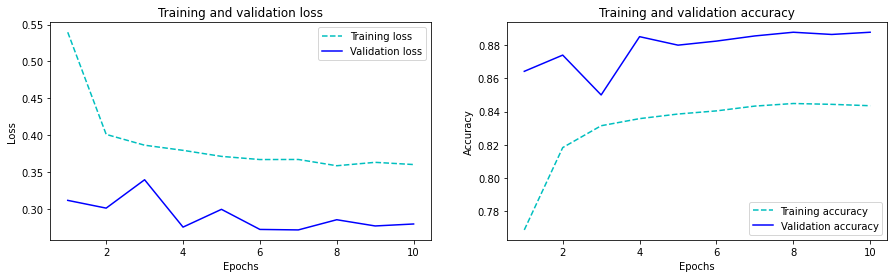

In [ ]:
show_result(history) 

Accuracy and loss aren't much different from the previous one. 

###Model 3 Increase No. of Epochs

####Build Model

In [ ]:
vgg = models.load_model('og_vgg16.h5')

In [ ]:
# Freeze All Layer
vgg.trainable = False

In [ ]:
# Modified Network to Add Fully Connected Layer and Output Layer
vgg_out = vgg.output
vgg_out = layers.Dropout(0.3, name = 'Dropout1') (vgg_out)
vgg_out = layers.Flatten(name = 'Flatten1') (vgg_out)
vgg_out = layers.Dense(512, activation = 'relu', name = 'Dense1') (vgg_out)
vgg_out = layers.Dropout(0.3, name = 'Dropout2') (vgg_out)

# Noted that 2-classes softmax = sigmoid
out_layer = layers.Dense(2, activation = 'softmax', name = 'output')(vgg_out)

vgg_mod = models.Model(vgg.input, out_layer)

In [ ]:
# Compile Model
vgg_mod.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

####Fit Model

In [ ]:
epochs = 20

history = vgg_mod.fit( 
    train_generator, 
    validation_data = validation_generator,
    epochs = epochs,
)

vgg_mod.save('vgg_20epoch.h5')

Last train accuracy: 0.8485555648803711
Last validation accuracy: 0.8886666893959045


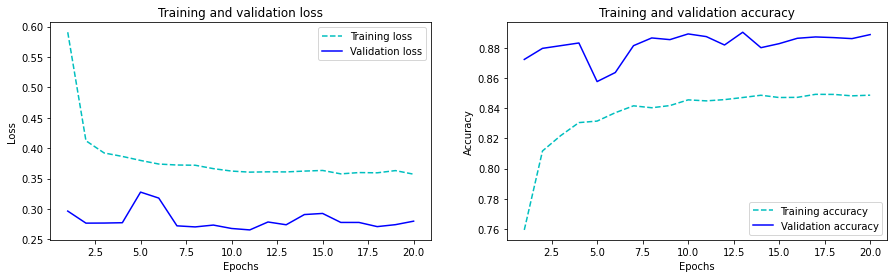

In [ ]:
show_result(history) 

After 10th epoch, the accuracy and loss are steady.

###Model 4 Fine Tuning

####Build Model

In [ ]:
# Load Base VGG and Freeze
vgg_base = models.load_model('og_vgg16.h5')
vgg_base.trainable = False

In [ ]:
# Modified Network to Add Fully Connected Layer and Output Layer
vgg_out = vgg_base.output
vgg_out = layers.Dropout(0.3, name = 'Dropout1') (vgg_out)
vgg_out = layers.Flatten(name = 'Flatten1') (vgg_out)
vgg_out = layers.Dense(512, activation = 'relu', name = 'Dense1') (vgg_out)
vgg_out = layers.Dropout(0.3, name = 'Dropout2') (vgg_out)

# Noted that 2-classes softmax = sigmoid
out_layer = layers.Dense(2, activation = 'softmax', name = 'output')(vgg_out)

vgg_mod = models.Model(vgg_base.input, out_layer)
vgg_mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

####Train the Top Layer

In [ ]:
vgg_mod.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 10

history = vgg_mod.fit( 
    train_generator, 
    validation_data = validation_generator,
    epochs = epochs,
)

vgg_mod.save('vgg_trainTop.h5')

Epoch 1/10
563/563 [==============================] - 135s 224ms/step - loss: 0.5786 - accuracy: 0.7571 - val_loss: 0.3516 - val_accuracy: 0.8393
Epoch 2/10
563/563 [==============================] - 123s 218ms/step - loss: 0.4095 - accuracy: 0.8136 - val_loss: 0.2895 - val_accuracy: 0.8704
Epoch 3/10
563/563 [==============================] - 123s 218ms/step - loss: 0.3911 - accuracy: 0.8271 - val_loss: 0.3156 - val_accuracy: 0.8647
Epoch 4/10
563/563 [==============================] - 130s 231ms/step - loss: 0.3836 - accuracy: 0.8323 - val_loss: 0.3542 - val_accuracy: 0.8473
Epoch 5/10
563/563 [==============================] - 131s 232ms/step - loss: 0.3811 - accuracy: 0.8329 - val_loss: 0.2884 - val_accuracy: 0.8811
Epoch 6/10
563/563 [==============================] - 141s 250ms/step - loss: 0.3744 - accuracy: 0.8372 - val_loss: 0.2859 - val_accuracy: 0.8776
Epoch 7/10
563/563 [==============================] - 124s 221ms/step - loss: 0.3685 - accuracy: 0.8389 - val_loss: 0.3479 -

Last train accuracy: 0.8400555849075317
Last validation accuracy: 0.8931111097335815


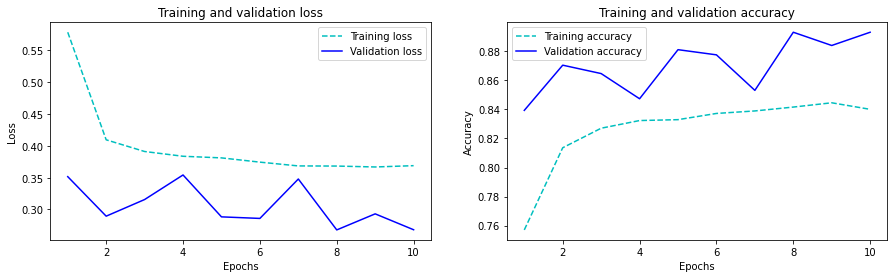

In [ ]:
show_result(history) 

####Fine Tuning

In [ ]:
# Unfreeze vgg Layer
vgg_base.trainable = True
vgg_mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# Compile with Low Learning Rate
vgg_mod.compile(optimizer = optimizers.RMSprop(0.00001), 
                loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 10

history = vgg_mod.fit( 
    train_generator, 
    validation_data = validation_generator,
    epochs = epochs,
)

vgg_mod.save('vgg_fineTune.h5')

Epoch 1/10
563/563 [==============================] - 147s 252ms/step - loss: 0.2438 - accuracy: 0.9008 - val_loss: 0.1197 - val_accuracy: 0.9536
Epoch 2/10
563/563 [==============================] - 146s 259ms/step - loss: 0.1573 - accuracy: 0.9385 - val_loss: 0.0810 - val_accuracy: 0.9669
Epoch 3/10
563/563 [==============================] - 139s 247ms/step - loss: 0.1294 - accuracy: 0.9499 - val_loss: 0.0853 - val_accuracy: 0.9693
Epoch 4/10
563/563 [==============================] - 139s 247ms/step - loss: 0.1119 - accuracy: 0.9577 - val_loss: 0.0769 - val_accuracy: 0.9689
Epoch 5/10
563/563 [==============================] - 138s 245ms/step - loss: 0.1066 - accuracy: 0.9617 - val_loss: 0.1257 - val_accuracy: 0.9571
Epoch 6/10
563/563 [==============================] - 138s 245ms/step - loss: 0.0984 - accuracy: 0.9634 - val_loss: 0.0698 - val_accuracy: 0.9778
Epoch 7/10
563/563 [==============================] - 138s 245ms/step - loss: 0.0888 - accuracy: 0.9689 - val_loss: 0.1166 -

Last train accuracy: 0.9717777967453003
Last validation accuracy: 0.9753333330154419


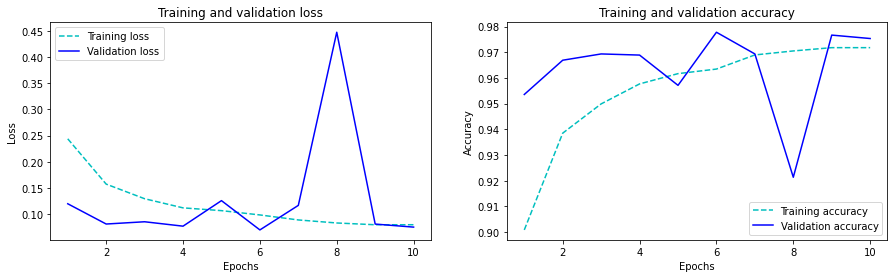

In [ ]:
show_result(history) 

After fine-tuning, the model is obvious better. Accuracy is above 95%.There is slightly signal of overfitting after 7th epochs from the loss graph that validation loss is increased. However, this model is good, and then evaluate model.

###Evaluation

In [ ]:
# Test Set Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_set, 
    directory = "/content/Cat_Dog_data/test", 
    x_col = 'Filename',
    y_col = None,
    target_size = IMAGE_SIZE,
    class_mode = None,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 2500 validated image filenames.


In [ ]:
# Load Final Model
vgg_final = models.load_model('vgg_fineTune.h5')

In [ ]:
# Calculate result
predict = vgg_final.predict(test_generator, steps=np.ceil(len(test_set)/BATCH_SIZE))

# Convert to Highest Probability
test_pred = pd.DataFrame()
test_pred['Category'] = np.argmax(predict, axis=-1)

# Convert Back to Classes
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_pred['Category'] = test_pred['Category'].replace(label_map)

In [ ]:
# Show report
print(confusion_matrix(test_set['Category'], test_pred['Category']))
print(classification_report(test_set['Category'], test_pred['Category']))

[[1214   36]
 [  31 1219]]
              precision    recall  f1-score   support

         cat       0.98      0.97      0.97      1250
         dog       0.97      0.98      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



From the confusion matrix and evaluation value, it's showed that model can do very well. Accuracy from test set, train set and validattion test are approximate 0.97, so it's not showed overfitting.  

###Predict with New Images

In [ ]:
def predict_img(img_path):
  # Load Image
  img = load_img(img_path, target_size=(128,128))
  img_tensor = image.img_to_array(img)

  # Show Image
  plt.imshow(img)

  # Preprocess data
  img_tensor = np.expand_dims(image.img_to_array(img), axis=0)/255.

  # Predict image with existing model
  img_pred = vgg_final.predict(img_tensor)

  # Convert to Highest Probability
  predict = np.argmax(img_pred, axis=-1)

  # Convert number to class (dog or cat)
  if predict == 0:
    result = 'cat'
  else:
    result = 'dog'
    
  return result

'dog'

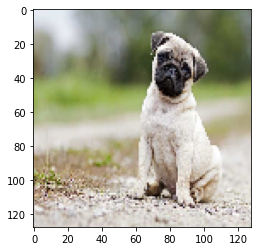

In [ ]:
result = predict_img('/content/dog1.jpg')
result

'cat'

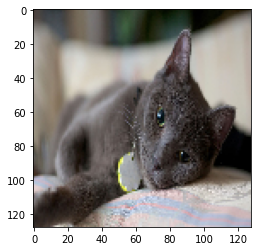

In [ ]:
result = predict_img('/content/cat1.jpg')
result

'cat'

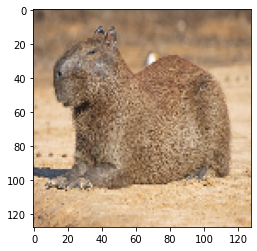

In [ ]:
result = predict_img('/content/capybara.jpg')
result

'dog'

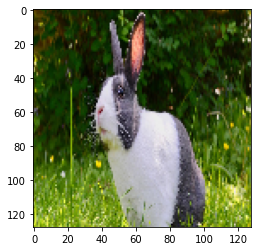

In [ ]:
result = predict_img('/content/rabbit.jpg')
result